In [1]:
from environment import GridWorld

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

### (I)

In [3]:
def get_policy(param, sigma):
    policy = np.exp(param*sigma)
    temp = np.exp(param*sigma)
    for i in range(0, policy.shape[0]):
        row_sum = temp[i].sum();
        for j in range(0, policy.shape[1]):
            policy[i][j] = policy[i][j]/ row_sum
    return policy

In [4]:
def get_return_over_episode(policy):
    env = GridWorld() 
    episode_return = env.reward
    while(not env.is_end_state()):

        (st, rw) = env.take_step(policy)
      
        episode_return += env.reward

    return episode_return    

In [5]:
def run_trial(params, sigma, policy=None):
    if(policy==None):
        policy = get_policy(np.reshape(params, (25, 4)), sigma)

    return_sum = 0
    gain_over_episodes = []
    for j in range(30):
        gain = get_return_over_episode(policy)
        return_sum += gain
        gain_over_episodes.append(gain)
    avg_return = return_sum / 30 

    return (avg_return, gain_over_episodes)

In [6]:
def run_trials(sigma):
    params = np.random.normal(0, 1, (100))
    (avg_return_old, gain_over_episode) = run_trial(params, sigma)
    gains = []
    gains.append(avg_return_old)
    for i in range(299):
        
        new_params = np.random.multivariate_normal(params, sigma*np.identity(100))
     
        (avg_return_new, new_gain_over_episode) = run_trial(new_params, sigma)
        gain_over_episode = [gain_over_episode[j] + new_gain_over_episode[j] for j in range(len(gain_over_episode))]
        gains.append(avg_return_new)
        if(avg_return_new > avg_return_old):

            params = new_params
            avg_return_old = avg_return_new
    gain_over_episode = [gain_over_episode[i]/300 for i in range(len(gain_over_episode))]
    return (gains, params, gain_over_episode)
        

In [7]:
gains_and_params = []
for i in range(1, 11):
    test_sigma = i/10
    (g, p) = run_trials(test_sigma)
    gains_and_params.append((g, p))


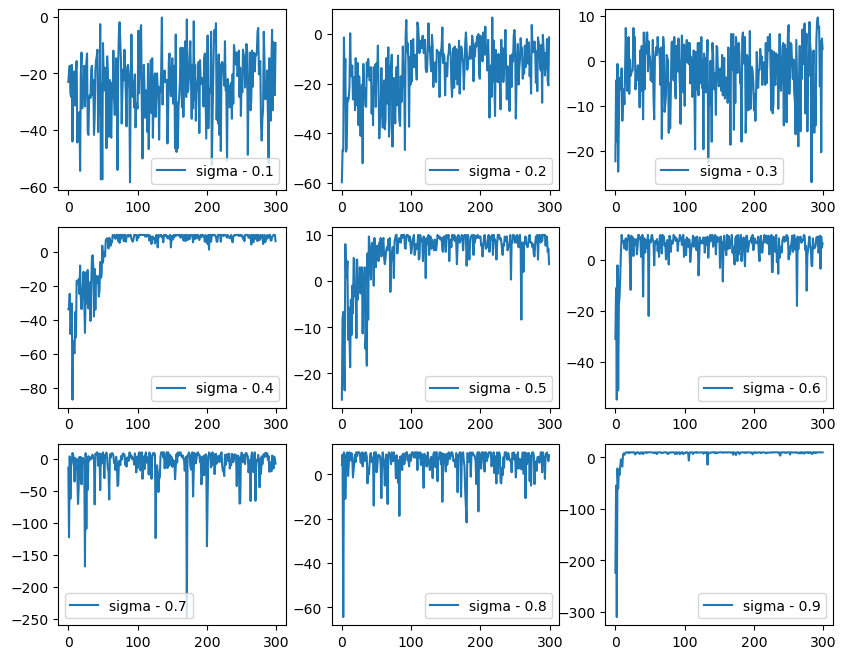

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
axs = axs.flatten()
for i in range(9):
    axs[i].plot(gains_and_params[i][0], label=("sigma - "+str((i+1)/10)))
    axs[i].legend()

#### From the above plots, we can infer that the best value for simga is 0.9

In [55]:
sig = 0.976
(g, p) = run_trials(sig)


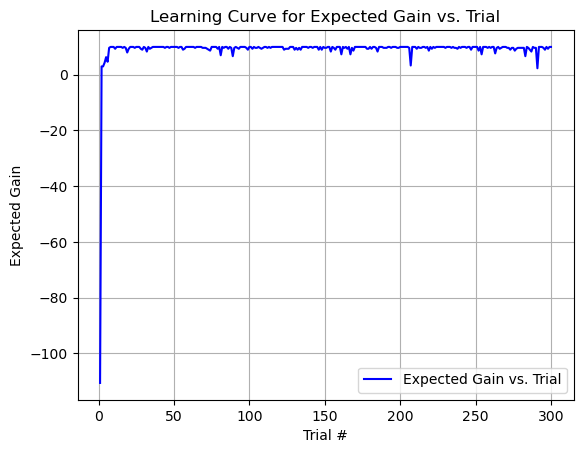

In [56]:
plt.plot([i for i in range(1, 301)], g, linestyle='-', color='b', label='Expected Gain vs. Trial')
plt.xlabel('Trial #')
plt.ylabel('Expected Gain')
plt.title('Learning Curve for Expected Gain vs. Trial')
plt.legend()  
plt.grid(True)
plt.show()

In [57]:
def get_averaged_curve(p, sigma, no_of_trials, no_of_episodes, policy=None):
    avg_curve = [0 for i in range(0, no_of_episodes)]
    for i in range(no_of_trials):
        (_, gain_over_episode) = run_trial(p, sigma, policy)
        avg_curve = [sum(x) for x in zip(avg_curve, gain_over_episode)]
    avg_curve = [x/no_of_trials for x in avg_curve]
    return avg_curve

In [58]:
averaged_curve = get_averaged_curve(p, sig, 300, 30)

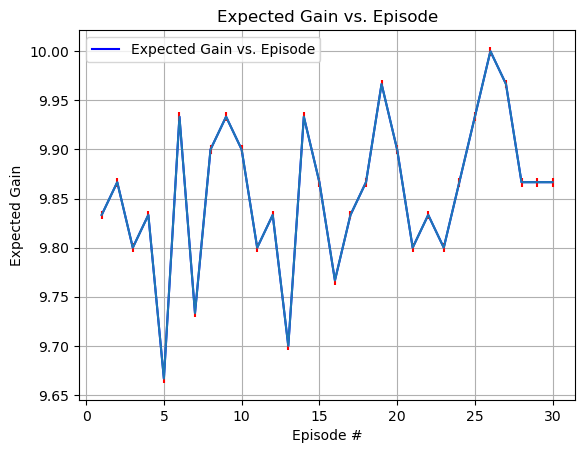

In [59]:
num_trials = 300
std_error = np.std(averaged_curve)/ np.sqrt(num_trials)
plt.plot([i for i in range(1, 31)], averaged_curve, linestyle='-', color='b', label='Expected Gain vs. Episode')
plt.errorbar([i for i in range(1, 31)], averaged_curve,yerr = std_error, ecolor='r')
plt.xlabel('Episode #')
plt.ylabel('Expected Gain')
plt.title('Expected Gain vs. Episode')
plt.legend()  
plt.grid(True)
plt.show()

### (II)

In [15]:
def get_state(action, current_state):
    new_state = current_state
    if(action == 0):
        new_state -= 5
    elif(action == 1):
        if(new_state%5 != 4):
            new_state += 1
    elif(action == 2):
        new_state += 5
    else:
        if(new_state%5 != 0):
            new_state -= 1
    if(new_state < 0 or new_state > 24 or new_state in [11, 17]):
        new_state = current_state
    return new_state

In [16]:
def get_prob(current_state, next_state, action):
    if(next_state in [11, 17]):
        return 0;
    prob = 0
    state_if_did_action = get_state(action, current_state)
    state_if_rotated_left = get_state((action+1)%4, current_state)
    state_if_rotated_right = get_state((action+3)%4, current_state)
    state_if_did_nothing = current_state
    if(state_if_did_action == next_state):
        prob += 0.8
    if(state_if_rotated_left == next_state):
        prob += 0.05
    if(state_if_rotated_right == next_state):
        prob += 0.05
    if(state_if_did_nothing == next_state):
        prob += 0.1
    
    return prob
    

In [17]:
def get_policy_from_value_iteration(eps):
    v = [(-3000) for i in range(25)]
    v[24] = 0
    pi = [[0,0,0,0] for i in range(25)]
    itr = 0
    env = GridWorld()
    mx_change = 100
    while(mx_change > eps):
        itr+=1
        mx_change = 0
        for i in range(24):
           
            action_v_reward = []
            for j in range(4):
                rsa = 0
                b = 0
                for k in range(25):
                    rsa += env.get_reward(k)*get_prob(i, k, j)
                    b += get_prob(i, k, j)*v[k]
                b *= env.gamma
                action_v_reward.append(rsa + b)
            for j in range(4):
                if(action_v_reward[j] > v[i]):
                    pi[i] = [0,0,0,0]
                    pi[i][j] = 1
                    mx_change = max(mx_change, action_v_reward[j] - v[i])
                    v[i] = action_v_reward[j];
    return (pi, v, itr)    
            

In [18]:
(pi, v, itr) = get_policy_from_value_iteration(0.0000001)

In [41]:
print("NUMBER OF ITERATIONS TAKEN TO CONVERGE - " + str(itr))

NUMBER OF ITERATIONS TAKEN TO CONVERGE - 29


In [45]:
averaged_curve_value_iteration = get_averaged_curve(None, None, 300, 30, pi)

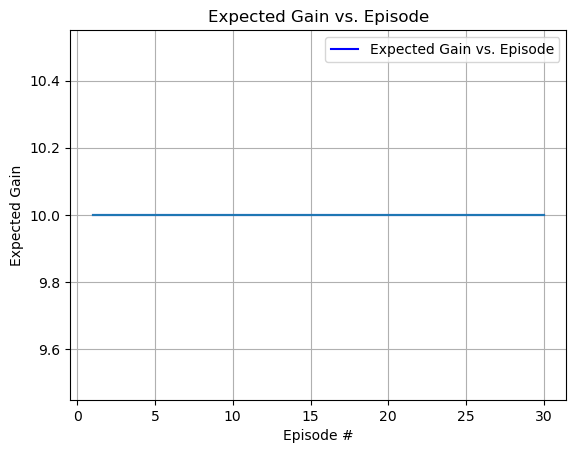

In [46]:
num_trials = 300
std_error = np.std(averaged_curve_value_iteration)/ np.sqrt(num_trials)
plt.plot([i for i in range(1, 31)], averaged_curve_value_iteration, linestyle='-', color='b', label='Expected Gain vs. Episode')
plt.errorbar([i for i in range(1, 31)], averaged_curve_value_iteration,yerr = std_error, ecolor='r')
plt.xlabel('Episode #')
plt.ylabel('Expected Gain')
plt.title('Expected Gain vs. Episode')
plt.legend()  
plt.grid(True)
plt.show()

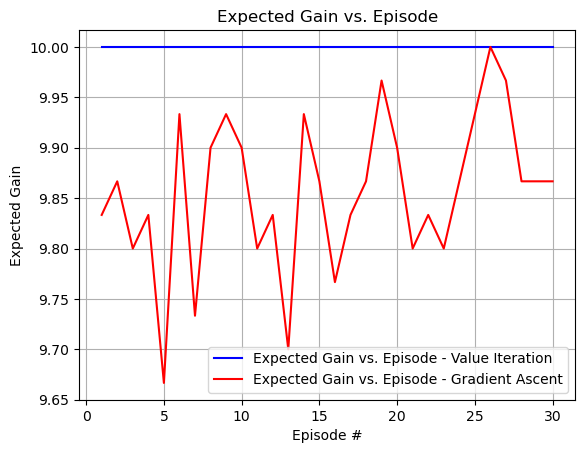

In [60]:
num_trials = 300
plt.plot([i for i in range(1, 31)], averaged_curve_value_iteration, linestyle='-', color='b', label='Expected Gain vs. Episode - Value Iteration')
plt.plot([i for i in range(1, 31)], averaged_curve, linestyle='-', color='r', label="Expected Gain vs. Episode - Gradient Ascent")
plt.xlabel('Episode #')
plt.ylabel('Expected Gain')
plt.title('Expected Gain vs. Episode')
plt.legend()  
plt.grid(True)
plt.show()